In [10]:
#pip install nbformat

In [10]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T
print(torch.__version__)

2.0.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [4]:
from pathlib import Path
current_directory = Path.cwd()

# Get the parent directory (one level up)
parent_directory = current_directory.parent
    
    
path_to_dataset =str(parent_directory)+'/captcha_dataset'

captchas = os.listdir(path_to_dataset)

Y = []
X = []
# png's are 3D and 4D but all dimension are the same execpt for the 4th which is all balck
# only turn png into array and keep the first dimension
for i,img_name in enumerate(captchas):
    Y.append(img_name[:5])

    new_path = path_to_dataset + '/' + captchas[i]

    image = Image.open(new_path)

    array_image = np.array(image) 

    X.append(array_image[:,:,0])

  

In [5]:
import string

all_characters= list(string.ascii_lowercase) + list(string.digits)

print(all_characters)

nchar = len(all_characters)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# make label array

y = np.zeros((5,len(Y),nchar)) #5*1070*36(5 letters in captcha) with all entries 0

for i,captcha in enumerate(Y):
   
  temp_label =np.zeros((5,nchar))

  for j, character in enumerate(captcha):
     
      character_index =  all_characters.index(character)
      temp_label[j,character_index] = 1
  y[:,i] = temp_label

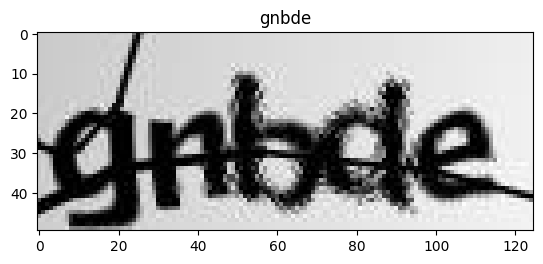

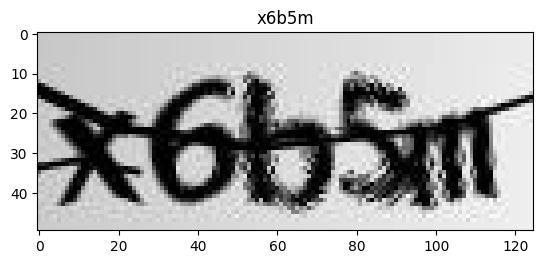

In [9]:
n = 2
rand_i = np.random.randint(0,len(Y),size=(n))
for i in range(len(rand_i)):
    plt.imshow(X[rand_i[i]][:,25:150],cmap='gray')
    plt.title(Y[rand_i[i]])
    plt.show()

In [ ]:
# CNN Model
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, imgshape, nchar):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))

        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))

        self.flatten = nn.Flatten()

        self.dens1 = nn.Linear(32 * 7 * 25, 64) # Calculate the input size based on the shapes

        self.dropout = nn.Dropout(0.5)
        self.dens_out = nn.Linear(64, nchar)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.mp1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.mp2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.mp3(x)

        x = self.flatten(x)
        x = self.dens1(x)
        x = self.relu3(x)

        outs = []
        for _ in range(5):
            x_drop = self.dropout(x)
            out = self.dens_out(x_drop)
            outs.append(out)

        return outs

# Define the input shape and number of characters in the output
imgshape = (1, 50, 200)
nchar = 5  # Replace 10 with the actual number of characters in the output (e.g., the number of classes in the classification task)

# Create the model
model = CustomModel(imgshape, nchar)


In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)